<h1 style="text-align: center;">Trainline Insurance Data Analysis</h1>
<h3 style="text-align: center;">A Model for Targeted Marketing</h3>

# Table of Contents
1. Introduction
    * 1.1 The Datasets
2. Exploratory Data Analysis
    * 2.1 Customer Dataset
    * 2.2 Transaction Dataset
3. Data Cleaning
4. Preprocessing
    * 4.1 Joining Datasets
    * 4.2 Feature Engineering
    * 4.3 Feature Aggregation
    * 4.4 Train - Test Split
5. Modelling
    * 5.1 Feature Selection
    * 5.2 Model Training and Optimisation
    * 5.3 Model Evaluation
6. Conclusions

# 1. Introduction
A key goal at Trainline is to grow revenue beyond train bookings by bolting on value added services to customers’ journeys. An important, and not well-understood, part of that revenue is travel insurance.

One possible way to increase revenue growth is via better targeted marketing. In this notebook, the propensity of Trainline customers to buy travel insurance is modelled with the purpose of improving the effectiveness of advertisement campaigns.

## 1.1 The Datasets
The data is provided into two separate tables, the first containing lifetime information about the customers, the second containing information about transactions these customers performed in the arc of a few months in 2015. The two datasets can be joined on the customer id.

### Customer Dataset
- **id**: unique customer identifier
- **country_name**: customer home country
- **reg_date**: customer registration date
- **retailer_marketing_opt_in**: customer subscribed to marketing (Y/N)
- **first_internet_trans_date**: cimestamp of first transaction over call internet
- **first_call_centre_trans_date**: timestamp of first transaction over call centre
- **first_mobile_app_trans_date**: timestamp of first transaction over mobile app
- **last_internet_trans_date**: timestamp of last transaction over call internet
- **last_call_centre_trans_date**: timestamp of last transaction over call centre
- **last_mobile_app_trans_date**: timestamp of last transaction over mobile app
- **lifetime_value**: lifetime value (GBP) of customer spent on Trainline
- **lifetime_transaction_count**: lifetime transaction count of customer on Trainline
- **purchased_ins_2015**: customer purchased travel insurance in 2015 (Y/N)

### Transaction Dataset
- **id**: booking unique id
- **customer_id**: id of customer who placed the booking
- **total_cost**: total cost (GBP) of tickets associated with booking and paid by customer
- **st_code_from**: unique identifier of origin station
- **st_code_to**: unique identifier of destination station
- **outbound_mileage**: mileage of outbound journey
- **return_mileage**: mileage of return journey
- **booking_date**: timestamp when the booking was placed
- **out_date_time**: timestamp when outbound journey begins
- **ret_date_time**: timestamp when return journey begins
- **adults_full_fare**: number of adults at full fare
- **adults_disc_fare**: number of adults at discounted fare
- **child_at_full_fare**: number of children at full fare
- **child_at_disc_fare**: number of children at discounted fare
- **class**: whether the tickets are first or second class (F/S)
- **ps_code**: railcard code of customer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Random seed for reproducibility
SEED = 42

In [2]:
# Load customer dataset
df_cu = pd.read_csv('./data/customer.csv', index_col='id')
df_cu.head()

,country_name,reg_date,retailer_marketing_opt_in,first_internet_trans_date,first_call_centre_trans_date,first_mobile_app_trans_date,last_internet_trans_date,last_call_centre_trans_date,last_mobile_app_trans_date,lifetime_value,lifetime_transaction_count,purchased_ins_2015
id,,,,,,,,,,,,
1,United Kingdom,2011-09-28,Y,2011-09-28 22:23:00,2015-01-02 13:17:00,NaN,2015-07-16 18:39:00,2015-01-02 13:17:00,NaN,133.3,9,Y
2,United Kingdom,2013-09-04,Y,2013-09-05 20:13:00,2015-01-02 14:31:00,NaN,2015-11-02 08:07:00,2015-01-02 14:31:00,NaN,1034.4,19,Y
3,"France, Metropolitan",2012-05-01,Y,2012-05-01 18:34:00,2015-01-03 11:40:00,NaN,2015-10-29 09:32:00,2015-01-03 11:40:00,NaN,629.9,12,N
4,United Kingdom,2015-01-03,Y,2015-01-16 13:53:00,2015-01-03 14:41:00,NaN,2015-01-16 13:53:00,2015-01-03 14:41:00,NaN,96.0,2,Y
5,United Kingdom,2014-09-10,Y,2014-09-10 14:56:00,2015-01-04 21:21:00,2014-11-28 17:45:00,2015-01-07 15:22:00,2015-01-04 21:21:00,2015-01-04 21:03:00,344.5,6,N


In [3]:
# Load transaction dataset
df_tr = pd.read_csv('./data/transaction.csv', index_col='id')
df_tr.head()

,customer_id,total_cost,st_code_from,st_code_to,outbound_mileage,return_mileage,booking_date,out_date_time,ret_date_time,adults_full_fare,adults_disc_fare,child_at_full_fare,child_at_disc_fare,class,ps_code
id,,,,,,,,,,,,,,,
1,1,25.4,CHD,SPT,48.56,48.56,2015-01-02 13:18:00,2015-01-02 15:20:00,2015-01-03 11:54:00,1,0,0,0,S,NaN
2,2,198.2,BUH,OXF,191.36,195.73,2015-01-02 14:34:00,2015-01-05 05:32:00,2015-01-09 15:36:00,1,0,0,0,S,NaN
3,3,56.0,SWI,NTA,136.18,130.77,2015-01-03 11:42:00,2015-01-05 17:41:00,2015-01-10 13:35:00,1,0,0,0,S,NaN
4,4,55.0,BDM,STP,49.99,49.99,2015-01-04 04:25:00,2015-02-17 10:17:00,NaN,2,0,0,0,S,NaN
5,5,45.5,SCA,KGX,188.50,NaN,2015-01-04 21:23:00,2015-02-18 10:15:00,NaN,0,2,0,0,S,2TR


# 2. Exploratory Data Analysis

## 2.1 Customer Dataset

### Prediction Target
The prediction target, `purchased_ins_2015`, is a balanced class: 24996 customers bought insurance in 2015 ('Y'), while 24995 did not ('N').

In [4]:
df_cu['purchased_ins_2015'].value_counts()

purchased_ins_2015
Y    24996
N    24995
Name: count, dtype: int64

### Registration Date
Customers in this dataset registred with Trainline between 1999 and 2015.

Text(0.5, 0, 'Registration Date')

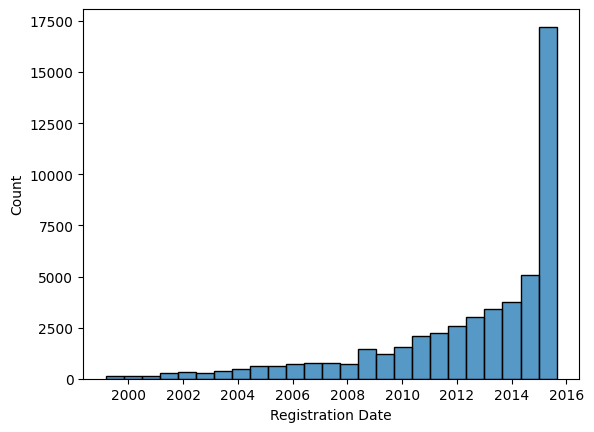

In [5]:
ax = sns.histplot(pd.to_datetime(df_cu['reg_date']), bins=25)
ax.set_xlabel('Registration Date')

### Lifetime Features
Lifetime features record the value (GBP) and transaction count of customers over their entire lifetime at Trainline.

Text(0.5, 0, 'Lifetime Transaction Count')

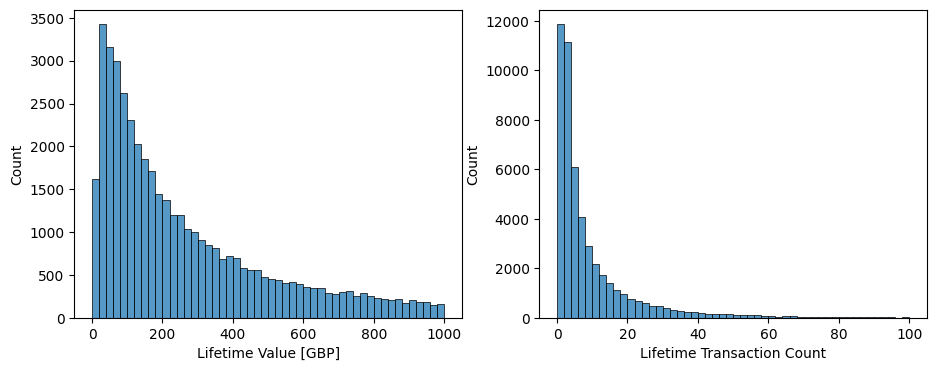

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1 = sns.histplot(df_cu['lifetime_value'], bins=50, binrange=(0, 1000), ax=ax1)
ax1.set_xlabel('Lifetime Value [GBP]')
ax2 = sns.histplot(df_cu['lifetime_transaction_count'], bins=50, binrange=(0, 100), ax=ax2)
ax2.set_xlabel('Lifetime Transaction Count')

### Missing Values
The customer dataset only has four columns with missing values: `first_call_centre_trans_date`, `last_call_centre_trans_date`, `first_mobile_app_trans_date`, `last_mobile_app_trans_date`.

The fact that more than 80% of these values are missing means that most customers never used the call centre or the mobile app to make their purchases, and the internet seems to be the preferred option. 

In [7]:
def plot_missing_values(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    f, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(rotation='vertical')
    sns.barplot(x=all_data_na.index, y=all_data_na)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

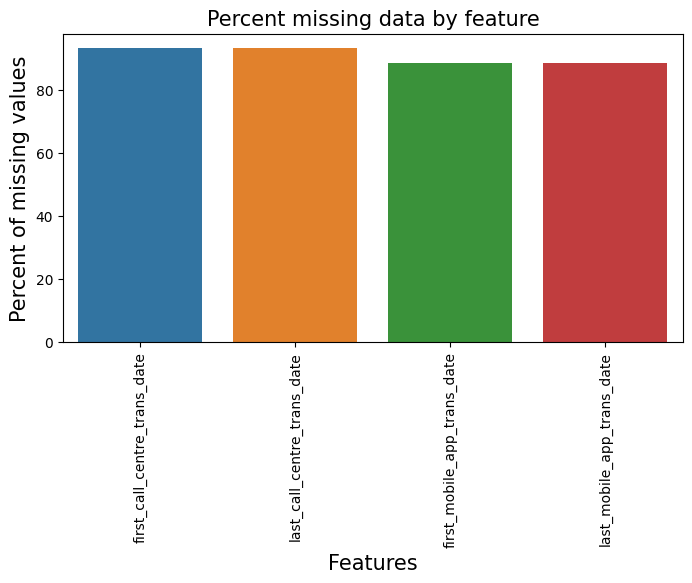

In [8]:
plot_missing_values(df_cu)

## 2.2 Transaction Dataset

### Mileage Features
The outbound mileage distribution is characterised by a long and quite continuous tail. Localised peaks are visible, corresponding to very popular fares.

As will be discussed later, around 65% of the `return_mileage` values are missing, as only a fraction of customers buy return tickets alongside outbound ones.

Among transactions where the return ticket was bought, 87.5% of the times the return mileage is exactly equal to the outbound mileage, meaning that the same railway was used for the two trips. This implies that the `outbound_mileage` and `return_mileage` columns are strongly correlated features.

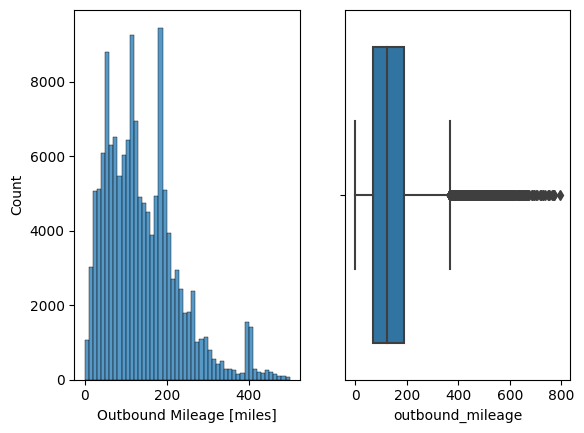

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = sns.histplot(df_tr['outbound_mileage'], bins=50, binrange=(0, 500), ax=ax1)
ax1.set_xlabel('Outbound Mileage [miles]')
ax2 = sns.boxplot(x=df_tr['outbound_mileage'], ax=ax2)

In [10]:
print(df_tr['outbound_mileage'].describe())

count    143207.000000
mean        141.908789
std          93.358788
min           0.340000
25%          70.590000
50%         124.530000
75%         189.080000
max         795.510000
Name: outbound_mileage, dtype: float64


In [11]:
# Number of transaction where the return ticket was purchased
n_tot = df_tr['return_mileage'].notna().sum()
# Number of transactions where outbound is equal to return mileage
n_eq = (df_tr['outbound_mileage'] == df_tr['return_mileage']).sum()
frac = n_eq / n_tot
print(f'Fraction of transactions where outbound is equal to return mileage: {frac:.3f}')

Fraction of transactions where outbound is equal to return mileage: 0.875


### Total Cost
The total transaction cost to the customer is characterised by a smoothly falling distribution with a long tail. By inspecting the box plot, a few outliers are visible. Their presence will be accounted for in Section 4.3, by aggregating the total cost feature with the median instead of the mean.

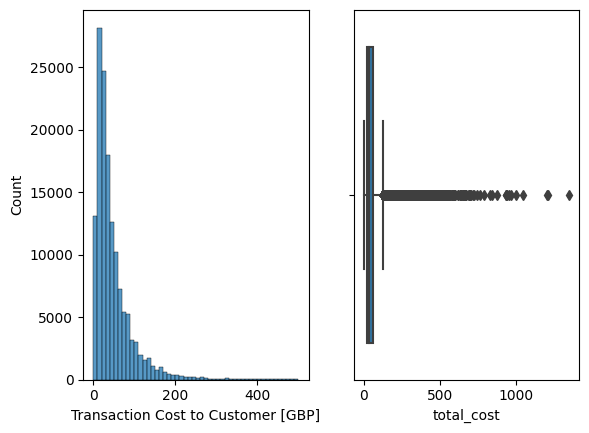

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = sns.histplot(df_tr['total_cost'], bins=50, binrange=(0, 500), ax=ax1)
ax1.set_xlabel('Transaction Cost to Customer [GBP]')
ax2 = sns.boxplot(x=df_tr['total_cost'], ax=ax2)

### Missing Values
The transaction dataset has four columns with missing values: `ret_date_time`, `return_mileage`, `ps_code` and `outbound_mileage`.

The first two are due to the fact that not all customers purchase return tickets alongide outbound ones. The fact that `ret_date_time` has around 80% missing values, while `return_mileage` only around 65% means that the return timestamp was not recorded for a fraction of purchased return tickets.

`ps_code` has around 65% missing values, while `outbound_mileage` an almost negligible fraction. As will be explained in the following section, some of these missing values can be corrected using knowledge about the dataset.

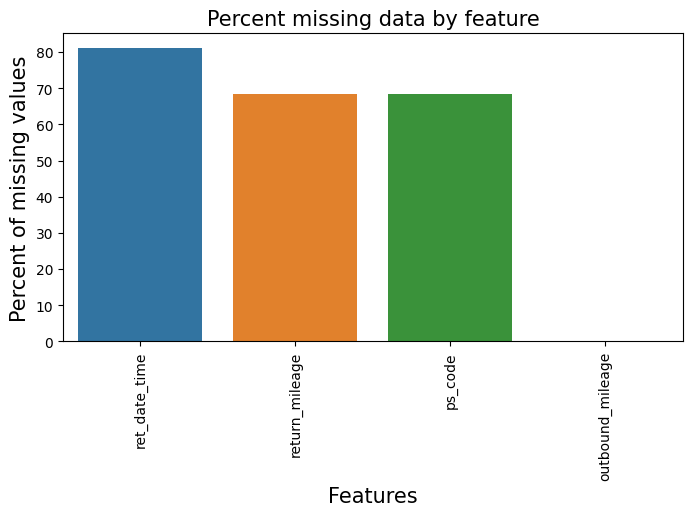

In [13]:
plot_missing_values(df_tr)

# 3. Data Cleaning
In this section, an attempt at correcting errors or inaccuracies in the data is made. Two features have evident errors that need to be corrected: the railcard type (`ps_code`) and the outbound trip mileage (`outbound_mileage`). Both of these features belong to the transaction dataset.

### Railcard Type (ps_code)
Customers might own a railcard, which can be of several different types (`ps_code`). A customer owning a railcard can use their railcard in a booking or not. It is thus possible to find the type of railcard by examining all transactions from a given customer and consider the only non null `ps_code` value.

`ps_code` has high cardinality. Therefore, only the most frequent categories are considered in the model, `YNG` (57.3%) and `SRN` (25.8%). We label the remaining categories with `OTHER` and whenever no railcard information is associated to a customer we label it as `NA`.

Finally, since we do not want to introduce any ordinal relationships between `ps_code` values, we apply one-hot encoding to this feature. We also drop the `NA` encoded column as it does not add information.

In [14]:
# Study ps_code cardinality
df_tr['ps_code'].value_counts(normalize=True)

ps_code
YNG    0.573030
SRN    0.258102
FAM    0.058873
2TR    0.038661
DIS    0.036922
HMF    0.017613
NEW    0.010436
NGC    0.004293
GS3    0.001057
JCP    0.000352
DIC    0.000176
DCR    0.000176
SRY    0.000154
HRC    0.000110
DRD    0.000022
STL    0.000022
Name: proportion, dtype: float64

In [15]:
def clean_ps_code(x: pd.Series) -> pd.Series:
    arr = x.dropna().to_numpy()
    if (len(arr) != 0):
        if arr[0] in ['YNG', 'SRN']:
            return arr[0]
        else:
            return 'OTHER'
    else:
        return 'NA'

In [16]:
# Apply data cleaning on ps_code
df_tr['id'] = df_tr.index
df_tr = df_tr.set_index('customer_id')
df_tr['ps_code'] = df_tr['ps_code'].groupby(df_tr.index).apply(clean_ps_code)
df_tr['customer_id'] = df_tr.index
df_tr = df_tr.set_index('id')

In [17]:
# Show ps_code cardinality after data cleaning
df_tr['ps_code'].value_counts(normalize=True)

ps_code
NA       0.589332
YNG      0.222764
SRN      0.097937
OTHER    0.089967
Name: proportion, dtype: float64

In [18]:
# One-hot encode
df_tr = pd.get_dummies(data=df_tr, columns=['ps_code'])
# Drop ps_code_NA (does not add info)
df_tr = df_tr.drop('ps_code_NA', axis=1)

### Outbound Mileage
There are missing values in the outbound mileage column. The best guess for these values is the mode mileage across all available transaction between the corresponding origin and destination stations. This procedure corrects most missing values and the remaining small fraction is removed from the dataset. 

In [19]:
def clean_outbound_mileage(row, df):
    value = row['outbound_mileage']
    origin = row['st_code_from']
    destination = row['st_code_to']
    if np.isnan(value):
        mode_val = df['outbound_mileage'][(df['st_code_from'] == origin) & (df['st_code_to'] == destination)].mode()
        if mode_val.empty:
            row['outbound_mileage'] = np.nan
        else:
            row['outbound_mileage'] = mode_val[0]
    return row

In [20]:
print('Number of missing values before cleaning: ' + str(df_tr['outbound_mileage'].isna().sum()))
# Apply data cleaning
df_tr = df_tr.apply(lambda row: clean_outbound_mileage(row, df_tr), axis=1)
print('Number of missing values after cleaning: ' + str(df_tr['outbound_mileage'].isna().sum()))
# Drop remaining missing values
df_tr = df_tr.dropna(subset=['outbound_mileage'])

Number of missing values before cleaning: 79
Number of missing values after cleaning: 35


# 4. Preprocessing
In this Section, the data is prepared before modelling. The following steps are applied:
* Join the customer and transaction datasets
* Engineer new features and discard unnecessary ones
* Aggregate transaction data
* Split train and test datasets

## 4.1 Joining Datasets
Each transaction in the transaction dataset holds the id (`customer_id`) of the customer who placed the booking. This column can be used to join the two datasets. We perform an inner join on the `id` column of the customer dataset and the `customer_id` column in the transaction dataset.

In [21]:
# Join datasets on customer id
df = df_cu.join(df_tr.set_index('customer_id'), how='inner')
df.head()

,country_name,reg_date,retailer_marketing_opt_in,first_internet_trans_date,first_call_centre_trans_date,first_mobile_app_trans_date,last_internet_trans_date,last_call_centre_trans_date,last_mobile_app_trans_date,lifetime_value,...,out_date_time,ret_date_time,adults_full_fare,adults_disc_fare,child_at_full_fare,child_at_disc_fare,class,ps_code_OTHER,ps_code_SRN,ps_code_YNG
id,,,,,,,,,,,,,,,,,,,,,
1,United Kingdom,2011-09-28,Y,2011-09-28 22:23:00,2015-01-02 13:17:00,NaN,2015-07-16 18:39:00,2015-01-02 13:17:00,NaN,133.3,...,2015-01-02 15:20:00,2015-01-03 11:54:00,1,0,0,0,S,True,False,False
1,United Kingdom,2011-09-28,Y,2011-09-28 22:23:00,2015-01-02 13:17:00,NaN,2015-07-16 18:39:00,2015-01-02 13:17:00,NaN,133.3,...,2015-01-02 15:20:00,2015-01-03 11:54:00,0,1,0,0,S,True,False,False
1,United Kingdom,2011-09-28,Y,2011-09-28 22:23:00,2015-01-02 13:17:00,NaN,2015-07-16 18:39:00,2015-01-02 13:17:00,NaN,133.3,...,2015-01-02 16:58:00,NaN,1,0,0,0,S,True,False,False
1,United Kingdom,2011-09-28,Y,2011-09-28 22:23:00,2015-01-02 13:17:00,NaN,2015-07-16 18:39:00,2015-01-02 13:17:00,NaN,133.3,...,2015-02-21 13:20:00,2015-02-22 13:54:00,0,1,0,0,S,True,False,False
1,United Kingdom,2011-09-28,Y,2011-09-28 22:23:00,2015-01-02 13:17:00,NaN,2015-07-16 18:39:00,2015-01-02 13:17:00,NaN,133.3,...,2015-03-28 16:20:00,2015-03-29 18:54:00,0,1,0,0,S,True,False,False


## 4.2 Feature Engineering

### Lifetime Columns
The customers' lifetime value and transaction counts are features that can only increase over time. Using these features might give good results on this particular dataset, but the model would be biased towards a specific time and its performance could decrease as new data is collected. To avoid this, we instead use the ratio between the lifetime value and transaction count, which is unbiased towards a specific time.

In [22]:
# Lifetime Value to Transaction Count Ratio
df['lifetime_val_trans_ratio'] = df['lifetime_value'] / df['lifetime_transaction_count']

### Binary Features
Some categorical features are actually binary:
* purchased_ins_2015
* retailer_marketing_opt_in
* class

In [23]:
# Binarize categorical features
df['purchased_ins_2015'] = df['purchased_ins_2015'].apply(lambda x: 1 if x == 'Y' else 0)
df['retailer_marketing_opt_in'] = df['retailer_marketing_opt_in'].apply(lambda x: 1 if x == 'Y' else 0)
df['class'] = df['class'].apply(lambda x: 1 if x == 'F' else 0)

### Datetime Features
An interesting feature to consider in the model is the time difference (in seconds) between the datetime of the outbound trip and that of the booking. Customers who book tickets in large advance might buy insurance more or less frequently than those who book at short notice.

In [24]:
# Time difference oubound - booking (seconds)
df['delta_t_out_book'] = (pd.to_datetime(df['out_date_time']) - pd.to_datetime(df['booking_date'])).dt.total_seconds()

### Mileage Features
Whenever bought, the return mileage of a trip is highly correlated with the outbound mileage. Large differences are present only when the return trip happens on a different railway line, which is quite rare (see Section 2.2). For this reason, only the outbound mileage feature is kept, alongside a new binary column (`return_bought`) describing whether or not the customer bought the return trip.

In [25]:
# Whether or not customer bought return
df['return_bought'] = df['return_mileage'].notna().astype(int)

### Number of Passengers
For each transaction the total number of adults and children associated with the ticket can be computed by summing the amount of people at full and discounted fares.

In [26]:
# Total number of adults
df['n_adults'] = df['adults_full_fare'] + df['adults_disc_fare']
# Total number of children
df['n_children'] = df['child_at_full_fare'] + df['child_at_disc_fare']

### User Type
In the dataset, every user has had a transaction over the internet at least once. However, not all of them use the call centre or mobile app for their purchases. We can encode this information as binary columns.

In [27]:
df['is_call_centre_user'] = df['first_call_centre_trans_date'].notna().astype(int)
df['is_mobile_app_user'] = df['first_mobile_app_trans_date'].notna().astype(int)

## 4.3 Feature Aggregation
The target we would like to predict (`purchased_ins_2015`) has one value per customer. However, to each customers are associated multiple transactions. Thus, if we want to predict the propensity of customers to buy travel insurance we must aggregate the transaction data.

In [28]:
# Aggregate transaction features
to_agg = [
    'outbound_mileage', 'return_bought', 'delta_t_out_book', 'n_adults', 'n_children',
    'class'
]
new_names = [f'{name}_mean' for name in to_agg]
df[new_names] = df[to_agg].groupby(df.index).mean()
# Aggregated with median to combat outliers
df['total_cost_median'] = df['total_cost'].groupby(df.index).median()
# Only keep first row per customer
df = df[~df.index.duplicated(keep='first')]

In [29]:
# Drop unnecessary features
to_keep = [
    # Customer columns
    'lifetime_val_trans_ratio', 'purchased_ins_2015', 'retailer_marketing_opt_in',
    'is_call_centre_user', 'is_mobile_app_user',
    # Transaction aggregated columns
    'outbound_mileage_mean', 'return_bought_mean', 'delta_t_out_book_mean', 'n_adults_mean',
    'n_children_mean', 'class_mean', 'total_cost_median',
    # One hot encoded columns
    'ps_code_YNG', 'ps_code_SRN', 'ps_code_OTHER'
]
df = df[to_keep]
df.head()

,lifetime_val_trans_ratio,purchased_ins_2015,retailer_marketing_opt_in,is_call_centre_user,is_mobile_app_user,outbound_mileage_mean,return_bought_mean,delta_t_out_book_mean,n_adults_mean,n_children_mean,class_mean,total_cost_median,ps_code_YNG,ps_code_SRN,ps_code_OTHER
id,,,,,,,,,,,,,,,
1,14.811111,1,1,1,0,50.297143,0.857143,3.978857e+04,1.000000,0.0,0.0,16.75,False,False,True
2,54.442105,1,1,1,0,169.286000,0.900000,4.582500e+05,1.000000,0.0,0.0,53.85,False,True,False
3,52.491667,0,1,1,0,116.376667,0.666667,1.188370e+06,1.000000,0.0,0.0,50.55,False,False,False
4,48.000000,1,1,1,0,49.990000,1.000000,7.693560e+06,2.000000,0.0,0.0,48.00,False,False,False
5,57.416667,0,1,1,1,162.266667,0.000000,3.201000e+06,1.333333,0.0,0.0,34.50,False,False,True


## 4.4 Train - Test Split
Here, we perform a 70% - 30% train - test split of the dataset.

In [30]:
# Features
X = df.drop('purchased_ins_2015', axis=1)
# Prediction target
y = df['purchased_ins_2015']
# Train - test split (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# 5. Modelling
The goal of this analysis is to find a model that describes the propensity of customers to buy travel insurance, and that would reveal useful in improving targeted marketing.

In this section, a random forest classifier model is trained, optimised and evaluated. The optimisation is done via k-fold cross validation, using recall as score.

Recall is defined as

$$Recall = \frac{TP}{TP + FN},$$

where TP is the number of true positives and FN is the number of false negatives.

The choice of this metric is explained by the fact that, for the purpose of a marketing model, false positives are not as deleterious as in other situations. In this case, it is instead more important to minimise the number of of customers that would buy insurance, but that are mislabelled by the model (false negatives).

## 5.1 Feature Selection
A feature can be bad at predicting the target for two main reasons:
1. It correlates strongly to other features
2. It correlates weakly to the prediction target

Intercorrelations can be studied with a correlation matrix, while the mutual information score can be used to gauge the ability of each feature to predict the target independently.

### Correlation Matrix
No extreme correlations are observed between features. The largest correlation (0.75) is between `lifetime_val_trans_ratio` and `total_cost_mean`, which is expected, since they are both cost features. Expected positive correlations (~0.45) are observed between the outbound mileage and the cost features: typically the longer the trip the higher the cost.

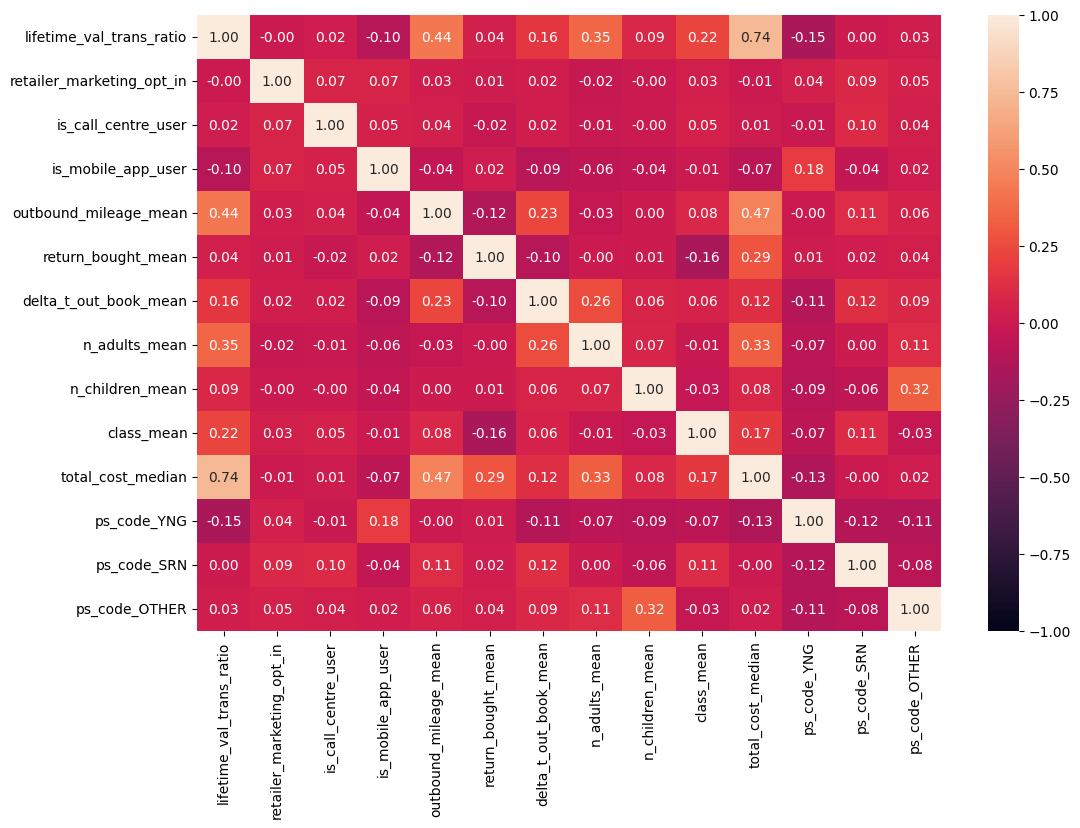

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(X_train.corr(numeric_only=True), annot=True, fmt=".2f", vmin=-1, vmax=1)

### Mutual information
Mutual information can be used to estimate the degree of univariate dependency between two variables. It can be used to rank the features and eliminate those that have little to no correlation to the prediction target.

Removing weakly-correlated features can help the modelling by reducing noise and prevent overfitting. The resulting models are also simpler and faster to train.

It must be noted that tree-based models are less affected by weakly-correlated and noisy features as they are characterised by embedded feature selection.

Here, the features in the training set are ranked according to their mutual information with the prediction target. Because of their very small scores, the following features are dropped: `is_mobile_app_user`, `is_call_centre_user`, `ps_code_OTHER`, `n_adults_mean`, `n_children_mean`.

In [32]:
def plot_mutual_info(X, y):
    """
    Draws bar plot of mutual information for each feature in X against prediction target y.
    """
    # Compute scores
    scores = mutual_info_classif(X, y)
    # Zip features names and corresponding scores
    name_score_zip = zip(X.columns, scores)
    # Sort by descreasing score value
    name_score_zip = sorted(name_score_zip, key=lambda x: x[1], reverse=True)
    # Extract sorted names and scores lists
    names = [x[0] for x in name_score_zip]
    scores = [x[1] for x in name_score_zip]
    # Create pandas series (scores indexed by feature names)
    df = pd.Series(scores, index=names)
    # Draw bar plot
    ax = df.plot(kind='bar')
    ax.set_ylim([0, None])
    ax.set_ylabel('Mutual Information')
    return ax

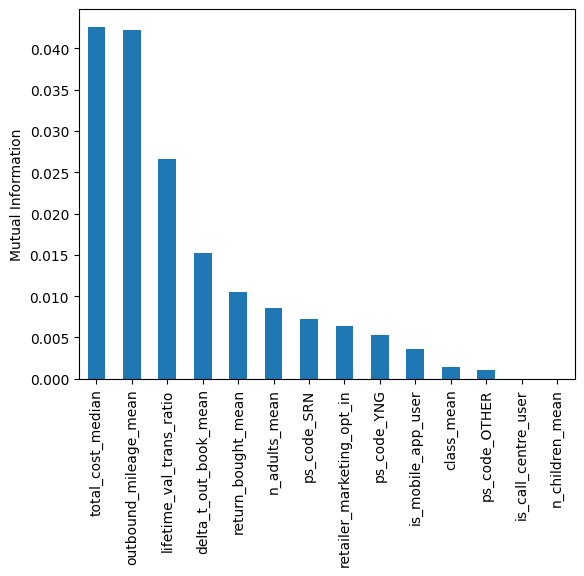

In [33]:
# Plot mutual information of training features and prediction target
ax = plot_mutual_info(X_train, y_train)

In [34]:
# Drop features with small mutual information
X_train = X_train.drop(
    ['is_mobile_app_user', 'is_call_centre_user', 'ps_code_OTHER', 'n_adults_mean', 'n_children_mean'],
    axis=1
)
X_test = X_test.drop(
    ['is_mobile_app_user', 'is_call_centre_user', 'ps_code_OTHER', 'n_adults_mean', 'n_children_mean'],
    axis=1
)

## 5.2 Model Training and Optimisation
In this section, the model is defined, trained and optimised. The model of choice is a random forest, trained on 70% of the data and optimised using 5-fold cross validation. As mentioned before, the model is optimised using the recall score.

In [35]:
# Define random forest model
rf_model = RandomForestClassifier(random_state=SEED)

# Set to True to run optimisation
optimize = False

if optimize:
    # Define hyperparameter space
    param_grid = {
        'n_estimators': [9, 10, 20, 30, 40],
        'max_depth': [4, 5, 6, 7, 10],
        'min_samples_split': [5, 6, 7, 8, 10],
        'min_samples_leaf': [2, 3, 4, 5, 10]
    }
else:
    param_grid = {
        'n_estimators': [30],
        'max_depth': [6],
        'min_samples_split': [5],
        'min_samples_leaf': [5]
    }

# Initialize optimizer
opt = GridSearchCV(rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='recall', verbose=0)

In [36]:
# Tune model
opt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [6], 'min_samples_leaf': [5],
                         'min_samples_split': [5], 'n_estimators': [30]},
             scoring='recall')

In [37]:
# Get best fitted model
rf_model = opt.best_estimator_
# Training recall score
train_score = recall_score(y_true=y_train, y_pred=rf_model.predict(X_train))
# Validation recall score
valid_score = opt.best_score_
print(f'Train score: {train_score:.3f}')
print(f'\nValidation score: {valid_score:.3f}')
print('\nBest hyperparameters:')
for name, value in opt.best_params_.items():
    print(f'{name:15s} \t{value}')

Train score: 0.662

Validation score: 0.661

Best hyperparameters:
max_depth       	6
min_samples_leaf 	5
min_samples_split 	5
n_estimators    	30


## 5.3 Model Evaluation
After optimisation, the best random forest model gives a mean recall score of 0.661 on the 5 cross validation folds. When evaluated on the training sample, the score is 0.662, meaning that the model is not overfitting the data after optimisation.

Since the cross validation folds are a good proxy for the test sample data, we expect to achieve a similar score when testing the model. On the test sample, the model achieves a recall score of 0.658 and an accuracy of 0.65.

In [38]:
# Random forest model test sample predictions
y_pred = rf_model.predict(X_test)
# Test sample metrics
test_accuracy_score = accuracy_score(y_true=y_test, y_pred=y_pred)
test_recall_score = recall_score(y_true=y_test, y_pred=y_pred)
test_precision_score = precision_score(y_true=y_test, y_pred=y_pred)
print('Test metrics:')
print(f'Accuracy: {test_accuracy_score:.3f}')
print(f'Recall: {test_recall_score:.3f}')
print(f'Precision: {test_precision_score:.3f}')

Test metrics:
Accuracy: 0.650
Recall: 0.658
Precision: 0.653


### Confusion Matrix
Another important metric used to measure a model's performace is the confusion matrix, which shows the true-negative, false-positive and false-negative and true positive rates, as measured on the test sample.

In any model optimisation process, one must strike a compromise between false negative and false positive rates. In this case, since the model was optimised by maximising recall, the false negative rate appears to be smaller than the false positive one. This is intended, as the model is to be used for targeted marketing where the largest number of potential insurance buyers must be reached.

In [39]:
def plot_conf_matrix(model, X, y):
    y_pred = model.predict(X)
    labels = model.classes_
    cm = confusion_matrix(y, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()

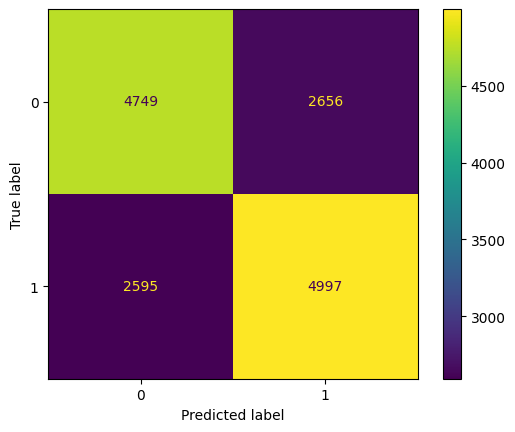

In [40]:
plot_conf_matrix(rf_model, X_test, y_test)

### Feature Imporances
Tree-based models are highly interpretable. In a random forest model, it is possible to rank its features based on their mean decrease in impurity, across all tree estimators. Highly ranked features are better at discriminating the classes in the prediction target and are thus used earlier in the tree.

Plotting the mean decrease in impurity is useful to understand which features are useful in the classification and which are less crucial. The mean outbound mileage and median total cost features appear to be the most important for the purpose of the classification, followed by the mean time difference between outbound trip and booking, the mean return purchase frequency and the lifetime value to transaction count ratio.

The large error bars for some of the features indicate that some estimators in the random forest rank them highly, others lowly (high variance).

In [41]:
def plot_importances(
    estimator,
    feature_names: list[str]
) -> plt.Axes:
    # Get feature importances (mean decrease in impurity) for the best random forest estimator
    importances = estimator.feature_importances_
    # Get importance variance
    std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)
    # Sort importances in decreasing order
    feat_imp_sort = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
    # Plot importances for each selected feature
    feature_names = [x[0] for x in feat_imp_sort]
    importances = [x[1] for x in feat_imp_sort]
    df_imp = pd.Series(importances, index=feature_names)
    ax = df_imp.plot(kind='bar')
    ax = df_imp.plot.bar(yerr=std, ax=ax)
    ax.set_ylim([0, None])
    ax.set_title('Feature Importance')
    ax.set_ylabel('Average Decrease in Impurity')
    return ax

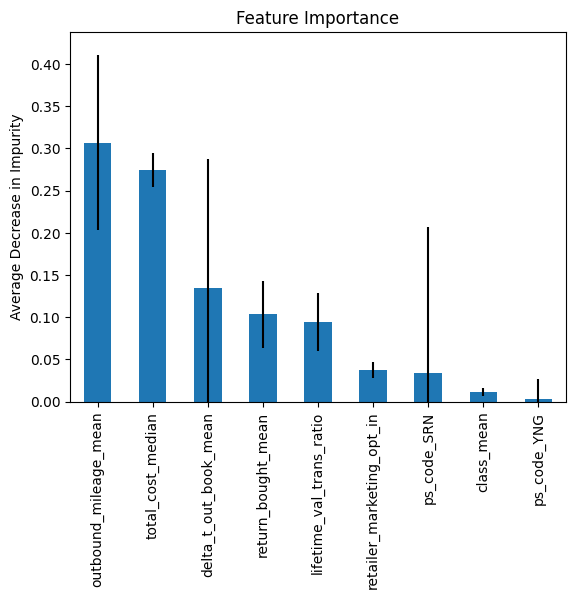

In [42]:
ax = plot_importances(rf_model, X_train.columns)

### ROC Curve
The random forest model obtained through hyperparameter optimisation is the one achieving the highest average recall score across the 5 CV folds (in the defined hyperparameter space).

The precision - recall tradeoff can further be tuned by varying the classification threshold of the model. This can be useful in satisfying particular needs of the business. For example, it might be beneficial to send advertisement to a larger pool of customers in order to reach more potential insurance buyers.

This, of course, is at the cost of giving a worse experience to a fraction of customers who already know about travel insurance or are not interested in buying it.

The operating point will be chosen according to constraints provided by the business, and requires further domain knowledge about costs and goals.

In [43]:
def plot_precision_recall(
    precision: np.ndarray,
    recall: np.ndarray,
    title: str = 'Precision - Recall Curve',
    x_label: str = 'Precision',
    y_label: str = 'Recall'
) -> plt.Axes:
    _, ax = plt.subplots()
    ax.plot(precision, recall)
    ax.set_title(title)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return ax

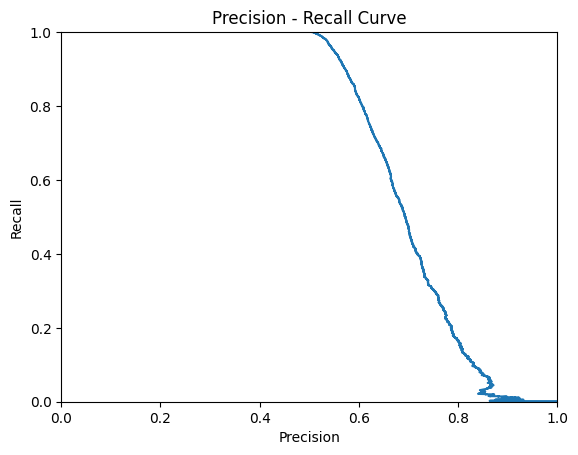

In [44]:
# Predict probabilities of classifying as 1
probs = rf_model.predict_proba(X_test)
preds = probs[:, 1]
# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, preds)
# plot precision - recall curve
ax = plot_precision_recall(precision, recall)

# 6. Conclusions
This analysis explores the modelling of the propensity of Trainline customers to buy travel insurance.

The dataset refers to around 50,000 customers and the transactions they performed in the arc of a few months in 2015. Half of the customers in the dataset bought travel insurance at least once, the others did not.

A random forest classifier was trained on 70% of the data and optimised using 5-fold cross-validation. Since for marketing purposes it is important to reach the largest possible fraction of potential insurance buyers, the model was optimised by maximising recall.

When evaluated on the test data (30% of the total dataset), the optimised model achieves an accuracy of 0.65 and a recall score of 0.658. This means that 65.8% of customers in the test sample who bought travel insurance are correctly identified by the model.

This model can potentially increase revenue growth for the company by helping to identify potential insurance buyers and target advertisement more effectively. If the model predicts a customer to have propensity to buy insurance, but they have not bought insurance yet, then they might not know about it. This model would allow to selectively send personalised advertisement to such customers, potentially increasing revenue growth.

Further domain knowledge is necessary for choosing an optimal precision vs. recall tradeoff. Furthermore, additional models and different preprocessing techniques could be explored in the future in order to improve the model's performance.